In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import StandardScaler
import numpy as np
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.cluster import HDBSCAN
import astropy.units as u
import astropy.coordinates as apycoords
import os
import glob
# from zero_point import zpt
from tqdm import tqdm
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('/Users/steven/Documents/NGC_6752_extra_tidal_5-result.csv') # full gaia sample for one cluster
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69235 entries, 0 to 69234
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   source_id                  69235 non-null  int64  
 1   ra                         69235 non-null  float64
 2   ra_error                   69235 non-null  float64
 3   dec                        69235 non-null  float64
 4   dec_error                  69235 non-null  float64
 5   l                          69235 non-null  float64
 6   b                          69235 non-null  float64
 7   parallax                   69235 non-null  float64
 8   parallax_error             69235 non-null  float64
 9   pmra                       69235 non-null  float64
 10  pmra_error                 69235 non-null  float64
 11  pmdec                      69235 non-null  float64
 12  pmdec_error                69235 non-null  float64
 13  phot_g_mean_mag            69234 non-null  flo

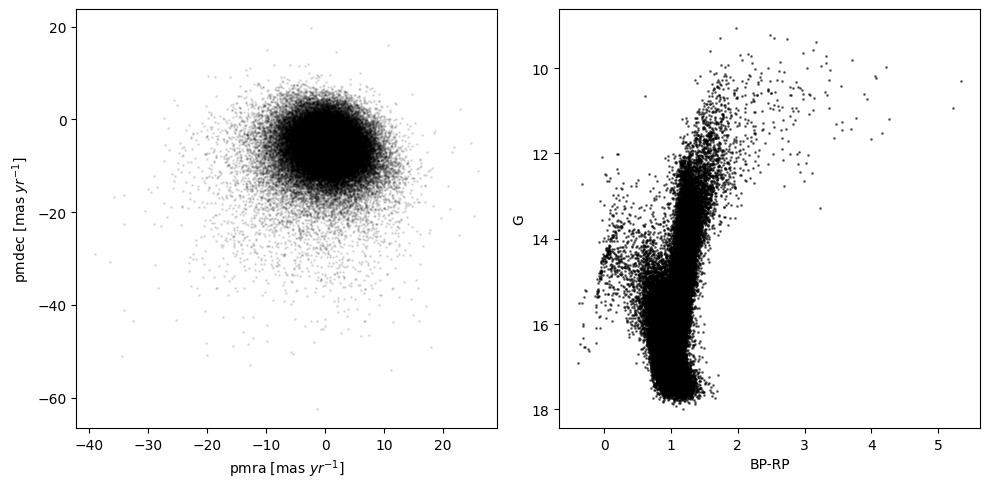

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(df['pmra'], df['pmdec'], s=1, alpha=0.1, c='k')
ax[0].set_xlabel("pmra [mas $yr^{-1}$]")
ax[0].set_ylabel("pmdec [mas $yr^{-1}$]")

ax[1].scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], s=1, alpha=0.5, c='k')
ax[1].set_xlabel("BP-RP")
ax[1].set_ylabel("G")
ax[1].invert_yaxis()
fig.tight_layout()

In [4]:
clustering_on = ['ra','dec','pmra','pmdec','parallax']

data = df[clustering_on]
data = RobustScaler().fit_transform(data)

# DBSCAN

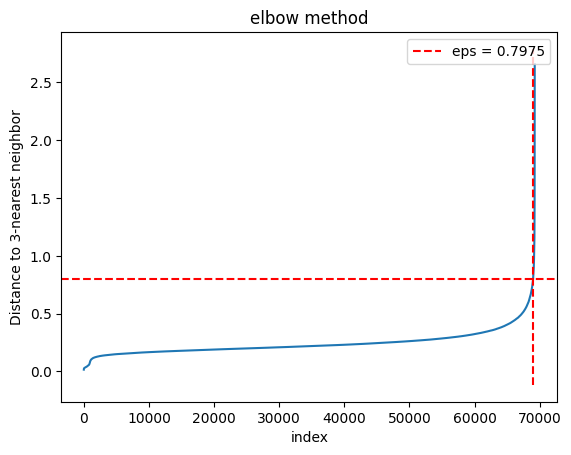

In [29]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

k = 3  # if min_samples = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(data)
distances, indices = nbrs.kneighbors(data)

k_distances = distances[:, -1]  # Última columna contiene la distancia al k-ésimo vecino
k_distances = np.sort(k_distances)

knee = KneeLocator(range(len(k_distances)), k_distances, curve="convex", direction="increasing")
eps_knee = k_distances[knee.knee]

plt.plot(k_distances)
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.axhline(y=eps_knee, color='r', linestyle='--', label=f"eps = {np.round(eps_knee, 4)}")
plt.xlabel("index")
plt.ylabel(f"Distance to {k}-nearest neighbor")
plt.title("elbow method")
plt.legend()
plt.show()

In [30]:
db = DBSCAN(eps=eps_knee, min_samples=10).fit(data) # n_jobs = 4

In [31]:
labels = db.labels_
df['label_db'] = labels
for i in list(set(labels)):
    print('{} {}'.format(i,len(df[(df['label_db'] == i)])))

0 68722
-1 513


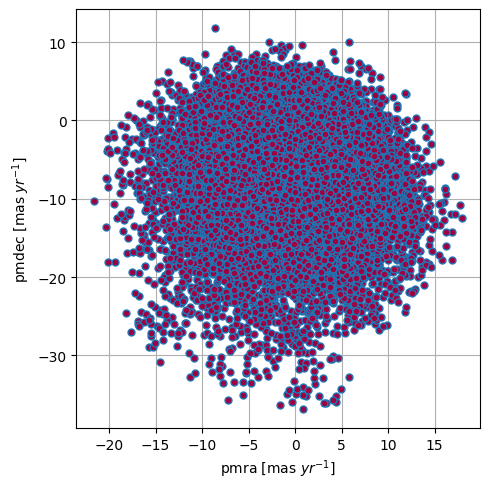

In [32]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(5,5))
for i, j in zip(list(unique_labels), colors):
    if i != -1:
        plt.plot(df['pmra'][(df['label_db'] == i)], df['pmdec'][(df['label_db'] == i)], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
plt.xlabel("pmra [mas $yr^{-1}$]")
plt.ylabel("pmdec [mas $yr^{-1}$]")
plt.tight_layout()
plt.grid()
plt.show() 

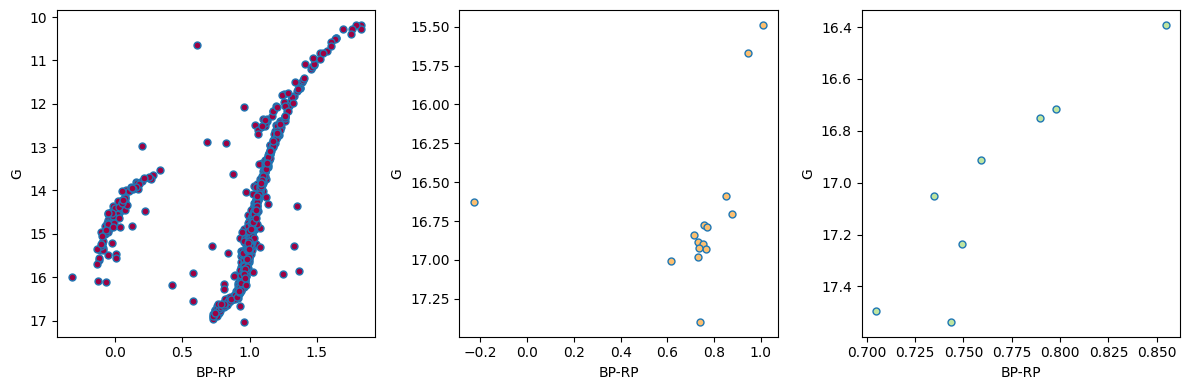

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i, j, ax in zip(list(unique_labels), colors, axes.flat):
    if i != -1:
        condition = (df['label_db'] == i)
        ax.plot(df['phot_bp_mean_mag'][condition] - df['phot_rp_mean_mag'][condition], df['phot_g_mean_mag'][condition], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
    ax.set_xlabel("BP-RP")
    ax.set_ylabel("G")
    ax.invert_yaxis()

fig.tight_layout()
plt.show() 

# HDBSCAN

In [24]:
#hd = HDBSCAN(min_cluster_size=20, min_samples=5, metric='mahalanobis', metric_params={'V': np.cov(data, rowvar=False)}).fit(data)
hd = HDBSCAN(min_cluster_size=50, min_samples=5, metric='euclidean').fit(data)

In [25]:
labels = hd.labels_ 
df['label_hb'] = labels
for i in list(set(labels)):
    print('{} {}'.format(i,len(df[(df['label_hb'] == i)])))

0 64
1 67
2 50
3 116
4 57
5 4209
6 1101
-1 63571


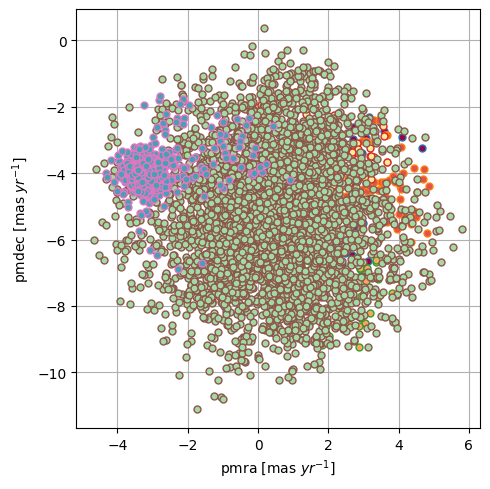

In [27]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(5,5))
for i, j in zip(list(unique_labels), colors):
    if i != -1:
        condition = (df['label_hb'] == i)
        plt.plot(df['pmra'][condition], df['pmdec'][condition], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
plt.xlabel("pmra [mas $yr^{-1}$]")
plt.ylabel("pmdec [mas $yr^{-1}$]")
plt.tight_layout()
plt.grid()
plt.show() 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


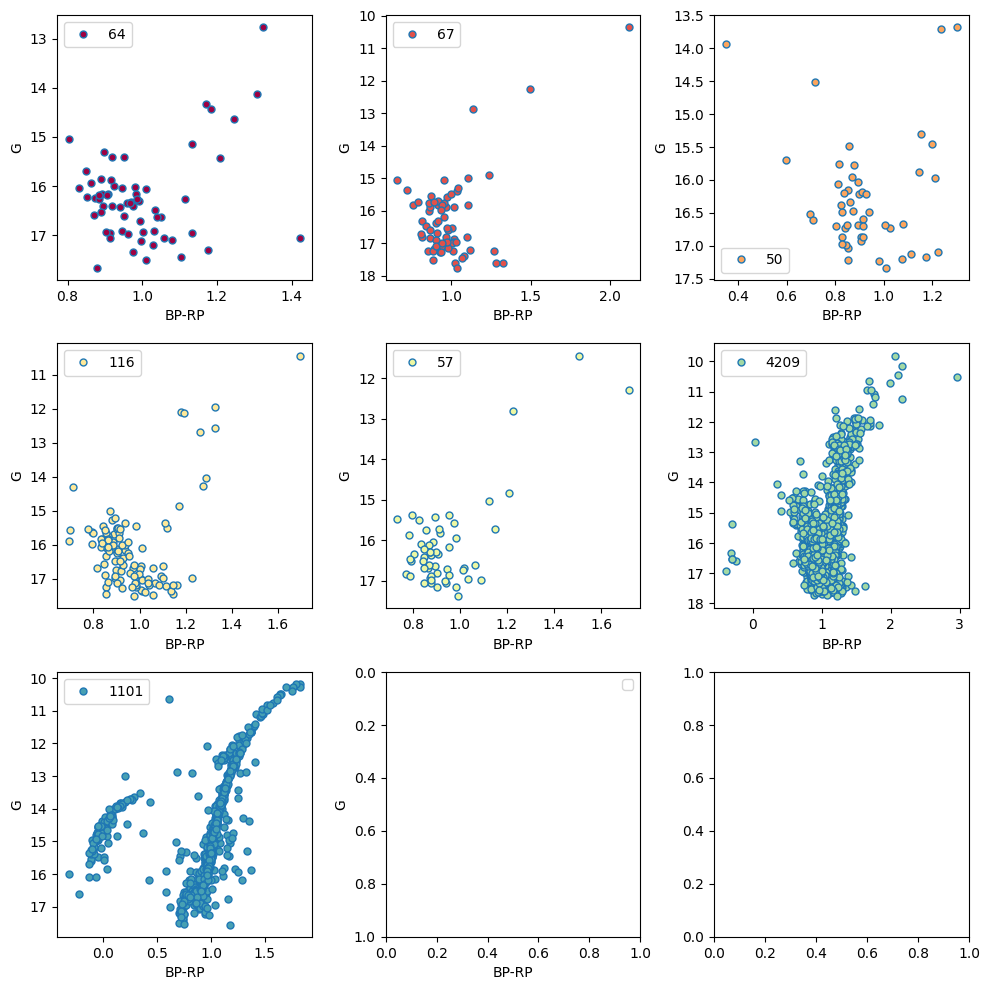

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))

for i, j, ax in zip(list(unique_labels), colors, axes.flat):
    if i != -1:
        condition = (df['label_hb'] == i)
        ax.plot(df['phot_bp_mean_mag'][condition] - df['phot_rp_mean_mag'][condition], df['phot_g_mean_mag'][condition], 
         markerfacecolor = tuple(j), marker='o', linestyle='None', markersize=5, label=f'{len(df[condition])}')
    ax.set_xlabel("BP-RP")
    ax.set_ylabel("G")
    ax.invert_yaxis()
    ax.legend()

fig.tight_layout()
plt.show() 